# **Текст задания**

Виртуальные ассистенты, устройства Internet-of-Things все больше входят в жизнь современного человека. Они не только помогают автоматизировать поисковые запросы, распознают лица и речь, выполняют простейшие команды, но и учатся вести мониторинг состояния здоровья, детектировать различные ситуации, информировать о важных для Пользователя событиях.

Для того, чтобы виртуальные ассистенты реагировали только на голос человека, присутствующего перед устройством, и не принимали во внимание речь из телевизора, радио, а также синтезированную, воспроизводимую роботами и другую, звучащую из динамиков, необходимы детекторы “живого” голоса.

Данная задача посвящена детектированию наличия “живого” голоса (класс 1) и его отделению от синтетического/конвертированного/перезаписанного голоса (класс 2).

Предлагается разработать систему с использованием элементов машинного обучения, которая обучается на заданной обучающей базе аудиозаписей и должна быть протестирована на тестовой базе аудиозаписей.



Исходные данные

Обучающая база данных:

Ссылка на базу: https://drive.google.com/file/d/13hVWxm4GbaFUj5SijJIZ40vTPSYnyNxq/view?usp=sharing

База имеет метки human (класс №1) и spoof (класс №2)

Тестовая база данных:

Ссылка на тестовую базу: https://drive.google.com/file/d/1-24PA2Fht7Hd3j40c5LelVsWgWfJhF07/view?usp=sharing

База не имеет меток правильных ответов



Критерии оценки

В качестве критерия будет использоваться метрика Equal Error Rate (равновероятная ошибка пропуска-отклонения - такая настройка порога принятия решения, при которой ошибки спутывания класса 1 с классом 2 и класса 2 с классом 1 будут равны и будут равны EER), рассчитанная на тестовой базе данных. Для расчета метрики необходимо выслать результат прогона алгоритма по тестовой базе данных на e-mail hr@idrnd.net


Форма представления результата

Текстовый файл с ответами системы на тестовой базе в формате:

<имя файла>, <score>

<имя файла>, <score>

....

<имя файла>, <score>

где score - значение выхода системы детектирования. Чем выше score, тем больше уверенность системы в том, что в файле был записан “живой” голос.

# Работа с данными

In [1]:
import librosa
import matplotlib.pyplot as plt
import librosa.display 
from google.colab import files
import IPython.display as ipd

In [2]:
!tar -xvf '/content/drive/MyDrive/AudioIDR&D/training_data.tar.gz'
!tar -xvf '/content/drive/MyDrive/AudioIDR&D/Testing_Data_MLTASK.tar.gz'

Streaming output truncated to the last 5000 lines.
Testing_Data/sample_0833.wav
Testing_Data/sample_2267.wav
Testing_Data/sample_1555.wav
Testing_Data/sample_4181.wav
Testing_Data/sample_0013.wav
Testing_Data/sample_3173.wav
Testing_Data/sample_0138.wav
Testing_Data/sample_4774.wav
Testing_Data/sample_4803.wav
Testing_Data/sample_2772.wav
Testing_Data/sample_2762.wav
Testing_Data/sample_0991.wav
Testing_Data/sample_2125.wav
Testing_Data/sample_1015.wav
Testing_Data/sample_0155.wav
Testing_Data/sample_3099.wav
Testing_Data/sample_3740.wav
Testing_Data/sample_4835.wav
Testing_Data/sample_0384.wav
Testing_Data/sample_2116.wav
Testing_Data/sample_1625.wav
Testing_Data/sample_1786.wav
Testing_Data/sample_4741.wav
Testing_Data/sample_2330.wav
Testing_Data/sample_1821.wav
Testing_Data/sample_0908.wav
Testing_Data/sample_2173.wav
Testing_Data/sample_4144.wav
Testing_Data/sample_1789.wav
Testing_Data/sample_0655.wav
Testing_Data/sample_3199.wav
Testing_Data/sample_1080.wav
Testing_Data/sample_1

(107825,) 22050
4.890022675736962


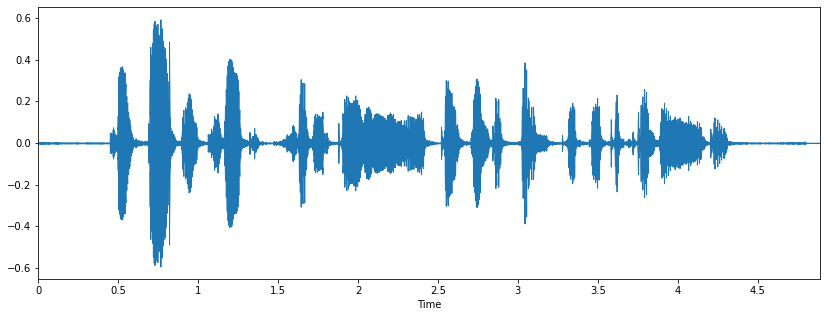

In [ ]:
audio_path = '/content/Training_Data/human/human_00000.wav'
x, sr = librosa.load(audio_path)

print(x.shape, sr)
print(x.shape[0]/sr)
ipd.Audio(audio_path)

plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
plt.show()

(99887,) 22050
4.530022675736961


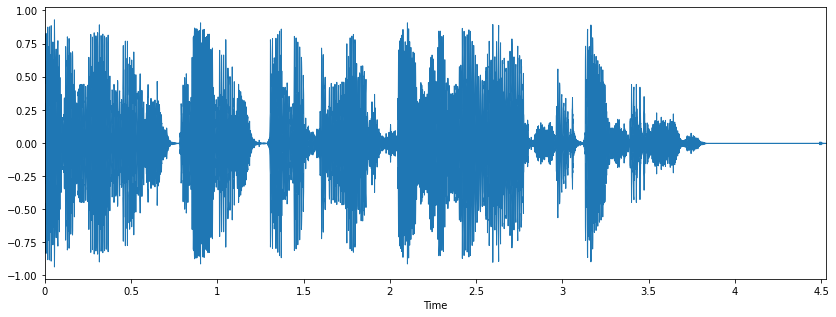

In [ ]:
audio_path_r = '/content/Training_Data/spoof/spoof_00000.wav'
x, sr = librosa.load(audio_path_r)

print(x.shape, sr)
print(x.shape[0]/sr)
ipd.Audio(audio_path_r)

plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import to_categorical

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [17]:
# Параметризация аудио

def get_features(y, sr):

  rmse = librosa.feature.rms(y=y)
  spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
  spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
  rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
  zcr = librosa.feature.zero_crossing_rate(y)
  mfcc = librosa.feature.mfcc(y=y, sr=sr)
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)

  out = rmse
  out = np.concatenate((out, spec_cent))    
  out = np.concatenate((out, spec_bw))      
  out = np.concatenate((out, rolloff))      
  out = np.concatenate((out, zcr))          
  out = np.concatenate((out, mfcc))
  out = np.concatenate((out, chroma_stft))

  return out

def getSetFromIndexes(audio, xLen, xStep):
  xSample = []
  audioLen = audio.shape[1]
  index = 0
  while (index + xLen <= audioLen):
    xSample.append(audio[:,index:index+xLen])
    index += xStep
  
  return np.array(xSample)

In [ ]:
classes = os.listdir('/content/Training_Data')

In [ ]:
print(classes)

['human', 'spoof']


In [ ]:
filename = '/content/Training_Data/human/human_00000.wav'
y, sr = librosa.load(filename, mono=True, duration=5)
out = get_features(y, sr)

print(out.shape)

out = getSetFromIndexes(out, 100, 200)
print(out.shape)

mfcc = librosa.feature.mfcc(y=y, sr=sr)
print(mfcc.shape)

(37, 211)
(1, 37, 100)
(20, 211)


In [ ]:
import time
from tqdm import tqdm

classes = os.listdir('/content/Training_Data')

X_train = []
y_train = []

xLen = 100
xStep = 200

curr_time = time.time()

for i in range(len(classes)):
  cl = classes[i]
  for filename in tqdm(os.listdir(f'/content/Training_Data/{cl}')):
    audioname = f'/content/Training_Data/{cl}/{filename}'
    y, sr = librosa.load(audioname, mono=True, duration=5)
    out = get_features(y, sr)
    # print('out before -> ' +  str(out.shape))

    out = getSetFromIndexes(out, xLen, xStep)
    # print('out after -> ' + str(out.shape))

    X_train.append(out)
    y_train.append(to_categorical(i, len(classes)))

  print("Класс ", cl, " готов за ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

X_train = np.array(X_train)
y_train = np.array(y_train)

  0%|          | 13/10322 [00:02<32:45,  5.25it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
100%|██████████| 10322/10322 [34:44<00:00,  4.95it/s]


Класс human готов за 2085c


100%|██████████| 39678/39678 [2:14:15<00:00,  4.93it/s]


Класс spoof готов за 8056c


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(np.amax(X_train))
print(np.amin(X_train))

(50000, 1, 37, 100)
(50000, 2)
10174.4384765625
-934.1353149414062


In [ ]:
X_train_backup = X_train.copy()
y_train_backup = y_train.copy()

In [ ]:
print(y_train)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train_backup, y_train_backup, test_size=0.1)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(45000, 1, 37, 100)
(45000, 2)
(5000, 1, 37, 100)
(5000, 2)


In [ ]:
def setNewSizeXY(x, y):
  newX = []
  newY = []
  for i in range(x.shape[0]):
    for j in range(x.shape[1]):
      newX.append(x[i,j])
      newY.append(y[i])

  newX = np.array(newX)
  newY = np.array(newY)

  return newX, newY

In [ ]:
X_test_backup = X_test
y_test_backup = y_test

In [ ]:
X_train, y_train = setNewSizeXY(X_train, y_train)
X_test, y_test = setNewSizeXY(X_test, y_test)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(45000, 37, 100)
(45000, 2)
(5000, 37, 100)
(5000, 2)


In [ ]:
sh = (-1, xLen*37)

X_train01 = X_train.reshape(sh)
X_test01 = X_test.reshape(sh)

print(X_train01.shape)
print(y_train.shape)
print(X_test01.shape)
print(y_test.shape)
print(np.amin(X_train01), np.amax(X_train01))

(45000, 3700)
(45000, 2)
(5000, 3700)
(5000, 2)
-934.1353149414062 10174.4384765625


In [ ]:
scaler = StandardScaler()
scaler.fit(X_train01)

X_train01 = scaler.transform(X_train01)
X_test01 = scaler.transform(X_test01)

print(np.amin(X_train01), np.amax(X_train01))
print(X_train01.shape)

-8.169033549373367 17.864045750288636
(45000, 3700)


In [ ]:
sh = (-1, xLen, 37)

X_train = X_train01.reshape(sh)
X_test = X_test01.reshape(sh)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(np.amin(X_train), np.amax(X_train))

(45000, 100, 37)
(45000, 2)
(5000, 100, 37)
(5000, 2)
-8.169033549373367 17.864045750288636


In [ ]:
np.save('/content/drive/MyDrive/AudioIDR&D/data/X_train.npy', X_train)
np.save('/content/drive/MyDrive/AudioIDR&D/data/y_train.npy', y_train)
np.save('/content/drive/MyDrive/AudioIDR&D/data/X_test.npy', X_test)
np.save('/content/drive/MyDrive/AudioIDR&D/data/y_test.npy', y_test)

In [ ]:
from pickle import dump
dump(scaler, open('/content/drive/MyDrive/AudioIDR&D/data/scaler.pkl', 'wb'))

In [5]:
X_train = np.load('/content/drive/MyDrive/AudioIDR&D/data/X_train.npy')
y_train = np.load('/content/drive/MyDrive/AudioIDR&D/data/y_train.npy')
X_test = np.load('/content/drive/MyDrive/AudioIDR&D/data/X_test.npy')
y_test = np.load('/content/drive/MyDrive/AudioIDR&D/data/y_test.npy')

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(45000, 100, 37)
(45000, 2)
(5000, 100, 37)
(5000, 2)


In [7]:
from pickle import load
scaler = load(open('/content/drive/MyDrive/AudioIDR&D/data/scaler.pkl', 'rb'))

# Создание и тренировка модели

In [9]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, Activation, Add, MaxPool1D, AveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
xLen = 100
classes = ['human', 'spoof']

input = Input((xLen, 37))

x1 = Conv1D(40, 3, padding='same', activation='elu')(input)
x1 = Conv1D(80, 3, padding='same', activation='elu')(x1)

x1 = Dropout(0.5)(x1)
x1 = BatchNormalization()(x1)

x1 = Conv1D(120, 3, padding='same', activation='elu')(x1)
x1 = Conv1D(160, 3, padding='same', activation='elu')(x1)

fin = Flatten()(x1)
fin = Dropout(0.5)(fin)
fin = BatchNormalization()(fin)
fin = Dense(1000, activation='elu')(fin)
fin = Dense(len(classes), activation='softmax')(fin)

model = Model(input, fin)
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
704/704 [==============================] - 246s 345ms/step - loss: 0.4344 - accuracy: 0.8844 - val_loss: 0.1997 - val_accuracy: 0.9304
Epoch 2/20
704/704 [==============================] - 239s 340ms/step - loss: 0.2023 - accuracy: 0.9235 - val_loss: 0.1838 - val_accuracy: 0.9352
Epoch 3/20
704/704 [==============================] - 245s 348ms/step - loss: 0.1539 - accuracy: 0.9413 - val_loss: 0.1618 - val_accuracy: 0.9448
Epoch 4/20
704/704 [==============================] - 239s 339ms/step - loss: 0.1223 - accuracy: 0.9544 - val_loss: 0.1025 - val_accuracy: 0.9632
Epoch 5/20
704/704 [==============================] - 239s 340ms/step - loss: 0.0972 - accuracy: 0.9634 - val_loss: 0.1086 - val_accuracy: 0.9580
Epoch 6/20
704/704 [==============================] - 239s 340ms/step - loss: 0.0848 - accuracy: 0.9672 - val_loss: 0.1092 - val_accuracy: 0.9678
Epoch 7/20
704/704 [==============================] - 238s 338ms/step - loss: 0.0750 - accuracy: 0.9716 - val_loss: 0.1128 -

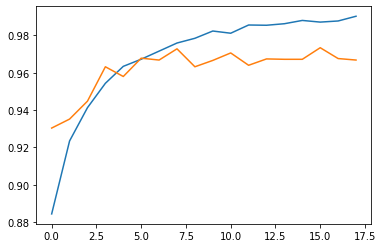

In [ ]:
model.compile(optimizer=Adam(lr=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_save_filename = "/content/drive/MyDrive/AudioIDR&D/data/model.h5"

earlystopping_cb = EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[earlystopping_cb, mdlcheckpoint_cb]
                    )

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [11]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/AudioIDR&D/data/model.h5')

In [12]:
y_pred = model.predict(X_test)

In [13]:
print(y_pred)

[[7.8814680e-04 9.9921179e-01]
 [4.2858927e-17 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 ...
 [1.0000000e+00 1.3690234e-24]
 [5.6543111e-22 1.0000000e+00]
 [1.3844118e-15 1.0000000e+00]]


In [14]:
num = 10

print(y_pred[num][0])
print(np.argmax(y_pred[num]))

3.308308e-17
1


In [80]:
# filename = '/content/Testing_Data/sample_2011.wav'
filename = '/content/Training_Data/spoof/spoof_00005.wav'

y, sr = librosa.load(filename, mono=True, duration=5)
out = get_features(y, sr)

In [81]:
ipd.Audio(filename)

In [82]:
print(X_test[0].shape)

(100, 37)


In [83]:
xLen = 100
xStep = 200

out = getSetFromIndexes(out, xLen, xStep)

In [84]:
print(out.shape)

(1, 37, 100)


In [85]:
sh = (-1, xLen*37)
newX = out.reshape(sh)
print(newX.shape)
newX01 = scaler.transform(newX)
sh = (-1, xLen, 37)
newX = newX01.reshape(sh)
print(newX.shape)

(1, 3700)
(1, 100, 37)


In [86]:
y = model.predict(newX)

In [87]:
print(y)
print(np.argmax(y))

[[0. 1.]]
1


In [101]:
print((y[0][0]))

3.7960352e-31


# Формируем файл с результатом

In [93]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/AudioIDR&D/data/model.h5')

In [103]:
from tqdm import tqdm

xLen = 100
xStep = 200

file = open("answer.txt", "w")

for filename in tqdm(os.listdir('/content/Testing_Data')):
  audioname = f'/content/Testing_Data/{filename}'
  y, sr = librosa.load(audioname, mono=True, duration=5)
  out = get_features(y, sr)

  out = getSetFromIndexes(out, xLen, xStep)

  sh = (-1, xLen*37)
  newX = out.reshape(sh)
  newX01 = scaler.transform(newX)
  sh = (-1, xLen, 37)
  newX = newX01.reshape(sh)

  y = model.predict(newX)

  answer = f'<{filename}>, <{y[0][0]}>,\n'
  file.write(answer)

file.close()

 65%|██████▍   | 3234/5000 [13:38<06:51,  4.29it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
100%|██████████| 5000/5000 [21:04<00:00,  3.95it/s]
